In [122]:
import math
import pickle
import sklearn
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.layers import BatchNormalization
from keras.layers import TimeDistributed
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data=pd.read_excel("/content/drive/MyDrive/Colab Notebooks/wind project/final data ERA5 24 hours.xlsx")

In [6]:
data


,# date,lat,lon,soil_temp,temp,solar_rd,u10,v10,soil_temp.1,temp.1,...,wind speed.3,Unnamed: 43,Unnamed: 44,solar_rd.4,u10.4,v10.4,soil_temp.5,temp.5,pressure.4,wind speed.4
0,2011-01-01,14.5,77.5,293.431,292.019,1.961410e+07,0.155315,1.399950,20.281,18.869,...,2.566997,NaN,NaN,1.961410e+07,0.155315,1.399950,20.281,18.869,95848.4,1.502179
1,2011-01-01,14.5,77.5,293.063,291.975,1.862650e-09,0.114499,1.303050,19.913,18.825,...,3.115833,NaN,NaN,1.862650e-09,0.114499,1.303050,19.913,18.825,95901.0,1.064268
2,2011-01-01,14.5,77.5,293.102,292.538,1.086020e+05,-0.272937,1.208260,19.952,19.388,...,3.408713,NaN,NaN,1.086020e+05,-0.272937,1.208260,19.952,19.388,95997.9,0.747660
3,2011-01-01,14.5,77.5,295.555,295.004,8.415560e+05,-0.401350,1.049350,22.405,21.854,...,3.495023,NaN,NaN,8.415560e+05,-0.401350,1.049350,22.405,21.854,96101.7,0.779042
4,2011-01-01,14.5,77.5,299.023,297.310,2.294920e+06,-0.516890,0.721392,25.873,24.160,...,3.752448,NaN,NaN,2.294920e+06,-0.516890,0.721392,25.873,24.160,96141.0,1.262038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95684,2021-11-30,14.5,77.5,295.158,294.168,1.327630e+07,-2.551080,NaN,22.008,21.018,...,NaN,NaN,NaN,1.327630e+07,-2.551080,NaN,22.008,21.018,NaN,NaN
95685,2021-11-30,14.5,77.5,295.109,294.074,1.327630e+07,-2.560500,NaN,21.959,20.924,...,NaN,NaN,NaN,1.327630e+07,-2.560500,NaN,21.959,20.924,NaN,NaN
95686,2021-11-30,14.5,77.5,295.131,294.094,1.327630e+07,-2.294890,NaN,21.981,20.944,...,NaN,NaN,NaN,1.327630e+07,-2.294890,NaN,21.981,20.944,NaN,NaN
95687,2021-11-30,14.5,77.5,295.089,294.012,1.327630e+07,-2.214200,NaN,21.939,20.862,...,NaN,NaN,NaN,1.327630e+07,-2.214200,NaN,21.939,20.862,NaN,NaN


In [7]:
df3h=data[["temp.2",'soil_temp.2','solar_rd.1','pressure.1','u10.1','v10.1','wind speed',"wind speed.1"]]

In [8]:
df3h

,temp.2,soil_temp.2,solar_rd.1,pressure.1,u10.1,v10.1,wind speed,wind speed.1
0,18.869,20.281,1.961410e+07,95848.4,0.155315,1.399950,1.408539,1.123484
1,18.825,19.913,1.862650e-09,95901.0,0.114499,1.303050,1.308071,0.887458
2,19.388,19.952,1.086020e+05,95997.9,-0.272937,1.208260,1.238704,0.636728
3,21.854,22.405,8.415560e+05,96101.7,-0.401350,1.049350,1.123484,0.922119
4,24.160,25.873,2.294920e+06,96141.0,-0.516890,0.721392,0.887458,1.553067
...,...,...,...,...,...,...,...,...
95684,21.018,22.008,1.327630e+07,NaN,-2.551080,NaN,2.551080,2.214200
95685,20.924,21.959,1.327630e+07,NaN,-2.560500,NaN,2.560500,2.057840
95686,20.944,21.981,1.327630e+07,NaN,-2.294890,NaN,2.294890,NaN
95687,20.862,21.939,1.327630e+07,NaN,-2.214200,NaN,2.214200,NaN


In [9]:
df3h=df3h[:90000]

In [10]:
df3h.describe()

,temp.2,soil_temp.2,solar_rd.1,pressure.1,u10.1,v10.1,wind speed,wind speed.1
count,90000.000000,90000.000000,9.000000e+04,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000
mean,26.931202,29.515442,1.444083e+07,95947.575214,0.739724,0.222411,3.202716,3.202760
std,4.775821,6.720845,8.239108e+06,327.585181,3.256255,1.226050,1.563829,1.563794
min,12.844000,15.024000,1.862650e-09,94864.100000,-7.145060,-6.181590,0.011003,0.011003
25%,23.611000,24.697000,7.611002e+06,95699.500000,-2.160270,-0.624168,2.050806,2.050907
50%,26.443000,28.004000,1.626740e+07,95935.200000,0.334119,0.336138,3.038441,3.038441
75%,29.953000,32.925000,2.121330e+07,96194.500000,3.672690,1.103350,4.167724,4.167724
max,41.062000,53.178000,2.793320e+07,97050.100000,10.352300,6.817320,10.352305,10.352305


In [11]:
df3h.isnull().sum()

,0
temp.2,0
soil_temp.2,0
solar_rd.1,0
pressure.1,0
u10.1,0
v10.1,0
wind speed,0
wind speed.1,0


In [12]:
x=df3h.iloc[:,:-1]
y=df3h.iloc[:,-1:]

In [13]:
x

,temp.2,soil_temp.2,solar_rd.1,pressure.1,u10.1,v10.1,wind speed
0,18.869,20.281,1.961410e+07,95848.4,0.155315,1.399950,1.408539
1,18.825,19.913,1.862650e-09,95901.0,0.114499,1.303050,1.308071
2,19.388,19.952,1.086020e+05,95997.9,-0.272937,1.208260,1.238704
3,21.854,22.405,8.415560e+05,96101.7,-0.401350,1.049350,1.123484
4,24.160,25.873,2.294920e+06,96141.0,-0.516890,0.721392,0.887458
...,...,...,...,...,...,...,...
89995,28.539,30.224,2.664550e+07,96100.9,-1.218290,1.445450,1.890385
89996,27.429,29.224,2.664550e+07,96033.7,-0.356766,1.823630,1.858200
89997,26.702,28.486,2.664550e+07,95951.3,0.283099,1.986080,2.006155
89998,25.731,27.599,2.664550e+07,95884.4,1.402390,2.070490,2.500725


In [14]:
y

,wind speed.1
0,1.123484
1,0.887458
2,0.636728
3,0.922119
4,1.553067
...,...
89995,2.500725
89996,2.794666
89997,2.847885
89998,2.462561


In [15]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,shuffle=False)

In [16]:
scaler=StandardScaler()
scaler.fit(x_train)

StandardScaler()

In [17]:
x_train_scaled=scaler.transform(x_train)
x_test_scaled=scaler.transform(x_test)

In [18]:
x_train_scaled.shape

(63000, 7)

In [19]:
def create_sequence(dataset, length):
    data_sequences = []
    for index in range(len(dataset) - length):
        data_sequences.append(dataset[index: index + length])
    return np.asarray(data_sequences)

In [20]:
x_train_scaled = create_sequence(x_train_scaled, 1)
x_test_scaled  = create_sequence(x_test_scaled, 1)
y_train = y_train[-x_train_scaled.shape[0]:]
y_test  = y_test[-x_test_scaled.shape[0]:]

In [21]:
x_train_scaled.shape[:]

(62999, 1, 7)

In [22]:
model = Sequential()

# First LSTM layer
model.add(LSTM(64, input_shape=(x_train_scaled.shape[1:]), activation='tanh', return_sequences=True))
model.add(BatchNormalization())  # Moved BatchNormalization before Dropout
model.add(Dropout(0.2))

# Second LSTM layer
model.add(LSTM(128, activation='tanh', return_sequences=True))  # Set return_sequences=True for deeper LSTMs
model.add(BatchNormalization())
model.add(Dropout(0.3))  # Slightly higher dropout to regularize

# Fourth LSTM layer
model.add(LSTM(128, activation='tanh'))  # Last LSTM layer does not need return_sequences
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Dense layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1, 64)               │          18,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 1, 128)              │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 258,433 (1009.50 KB)

 Trainable params: 257,793 (1007.00 KB)

 Non-trainable params: 640 (2.50 KB)

In [25]:
history= model.fit(x_train_scaled,y_train,validation_split=0.2,epochs=100,batch_size=512)

Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 1.6283 - mean_absolute_error: 1.6283 - val_loss: 2.5208 - val_mean_absolute_error: 2.5208
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 1.0318 - mean_absolute_error: 1.0318 - val_loss: 2.0292 - val_mean_absolute_error: 2.0292
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.9170 - mean_absolute_error: 0.9170 - val_loss: 1.4480 - val_mean_absolute_error: 1.4480
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.8665 - mean_absolute_error: 0.8665 - val_loss: 1.0561 - val_mean_absolute_error: 1.0561
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8219 - mean_absolute_error: 0.8219 - val_loss: 0.8533 - val_mean_absolute_error: 0.8533
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.8034 - mean_absolute_error: 0.8034 - val_loss: 0.7830 - val_mean_absolute_error: 0.7830
Epoch 7/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.7955 - mean_absolute_error: 0.7955 - 

In [26]:
predictions3h=model.predict(x_test_scaled)

844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [27]:
mse,mae=model.evaluate(x_test_scaled,y_test)
print("mean squared error",mse)
print("mean absolute error",mae)

844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6528 - mean_absolute_error: 0.6528
mean squared error 0.636447548866272
mean absolute error 0.636447548866272


In [28]:
rmse=math.sqrt(mse)
rmse

0.7977766284282035

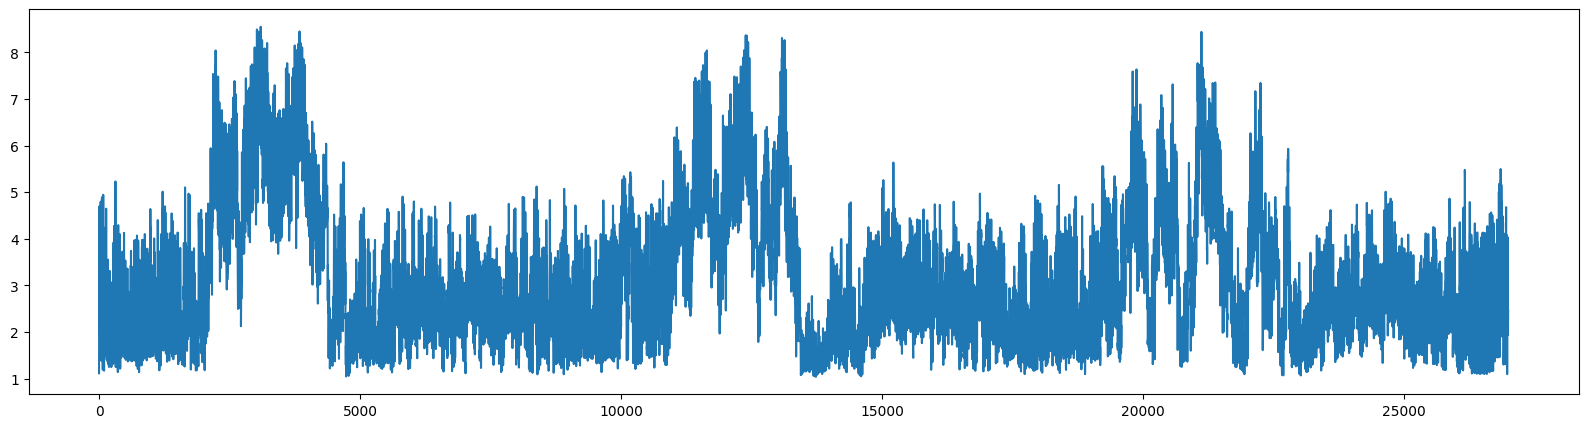

In [29]:
plt.figure(figsize=(20,5))
plt.plot(predictions3h)


In [30]:
#saving the values
pred3h=pd.DataFrame(predictions3h)
pred3h.to_csv('rnn prediction 3h.csv')
y_test.to_csv('rnn test_values 3h.csv')

In [31]:
with open('rnn3h.pickle','wb') as f3:
  pickle.dump(model,f3)

In [32]:
with open('rnn3h.pickle','rb') as f3:
  fm3=pickle.load(f3)

In [33]:
predictions3=fm3.predict(x_test_scaled)

844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [34]:
mse=mean_squared_error(y_test,predictions3)
print("MSE:",mse)

mae=mean_absolute_error(y_test, predictions3)
print("MAE:",mae)

rmse=math.sqrt(mse)
print("RMSE :",rmse)

r2=r2_score(y_test,predictions3)
print("r2 coeffient :",r2)

MSE: 0.7038431397760434
MAE: 0.6364470899129617
RMSE : 0.8389535981066196
r2 coeffient : 0.7072183591032645


wind speed for next 6 hours

In [70]:
df6h=data[["temp.3",'soil_temp.3','solar_rd.2','pressure.2','u10.2','v10.2','wind speed','wind speed.1',"wind speed.2"]]

In [71]:
df6h

,temp.3,soil_temp.3,solar_rd.2,pressure.2,u10.2,v10.2,wind speed,wind speed.1,wind speed.2
0,18.869,20.281,1.961410e+07,95848.4,0.155315,1.399950,1.408539,1.123484,0.922119
1,18.825,19.913,1.862650e-09,95901.0,0.114499,1.303050,1.308071,0.887458,1.553067
2,19.388,19.952,1.086020e+05,95997.9,-0.272937,1.208260,1.238704,0.636728,1.851348
3,21.854,22.405,8.415560e+05,96101.7,-0.401350,1.049350,1.123484,0.922119,1.940464
4,24.160,25.873,2.294920e+06,96141.0,-0.516890,0.721392,0.887458,1.553067,1.946160
...,...,...,...,...,...,...,...,...,...
95684,21.018,22.008,1.327630e+07,NaN,-2.551080,NaN,2.551080,2.214200,NaN
95685,20.924,21.959,1.327630e+07,NaN,-2.560500,NaN,2.560500,2.057840,NaN
95686,20.944,21.981,1.327630e+07,NaN,-2.294890,NaN,2.294890,NaN,NaN
95687,20.862,21.939,1.327630e+07,NaN,-2.214200,NaN,2.214200,NaN,NaN


In [72]:
df6h=df6h[:90000]

In [73]:
x=df6h.iloc[:,:-1]
y=df6h.iloc[:,-1:]

In [74]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,shuffle=False)

In [75]:
scaler=StandardScaler()
scaler.fit(x_train)

StandardScaler()

In [76]:
x_train_scaled=scaler.transform(x_train)
x_test_scaled=scaler.transform(x_test)

In [77]:
x_train_scaled = create_sequence(x_train_scaled, 1)
x_test_scaled  = create_sequence(x_test_scaled, 1)
y_train = y_train[-x_train_scaled.shape[0]:]
y_test  = y_test[-x_test_scaled.shape[0]:]

In [78]:
x_train_scaled.shape

(62999, 1, 8)

In [79]:
model = Sequential()

# First LSTM layer
model.add(LSTM(64, input_shape=(x_train_scaled.shape[1:]), activation='tanh', return_sequences=True))
model.add(BatchNormalization())  # Moved BatchNormalization before Dropout
model.add(Dropout(0.2))

# Second LSTM layer
model.add(LSTM(128, activation='tanh', return_sequences=True))  # Set return_sequences=True for deeper LSTMs
model.add(BatchNormalization())
model.add(Dropout(0.3))  # Slightly higher dropout to regularize

# Fourth LSTM layer
model.add(LSTM(128, activation='tanh'))  # Last LSTM layer does not need return_sequences
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Dense layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 1, 64)               │          18,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 1, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 1, 128)              │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 1, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 258,689 (1010.50 KB)

 Trainable params: 258,049 (1008.00 KB)

 Non-trainable params: 640 (2.50 KB)

In [80]:
history= model.fit(x_train_scaled,y_train,validation_split=0.2,epochs=100,batch_size=512)

Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 2.0605 - mean_absolute_error: 2.0605 - val_loss: 2.6160 - val_mean_absolute_error: 2.6160
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0662 - mean_absolute_error: 1.0662 - val_loss: 2.1355 - val_mean_absolute_error: 2.1355
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9519 - mean_absolute_error: 0.9519 - val_loss: 1.5642 - val_mean_absolute_error: 1.5642
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.8837 - mean_absolute_error: 0.8837 - val_loss: 1.0290 - val_mean_absolute_error: 1.0290
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8503 - mean_absolute_error: 0.8503 - val_loss: 0.8141 - val_mean_absolute_error: 0.8141
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.8247 - mean_absolute_error: 0.8247 - val_loss: 0.6988 - val_mean_absolute_error: 0.6988
Epoch 7/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.8019 - mean_absolute_error: 0.8019 - v

In [81]:
predictions6h=model.predict(x_test_scaled)

844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [82]:
mse,mae=model.evaluate(x_test_scaled,y_test)
print("mean squared error",mse)
print("mean absolute error",mae)

844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6958 - mean_absolute_error: 0.6958
mean squared error 0.6676809787750244
mean absolute error 0.6676809787750244


In [83]:
rmse=math.sqrt(mse)
rmse

0.8171174816236796

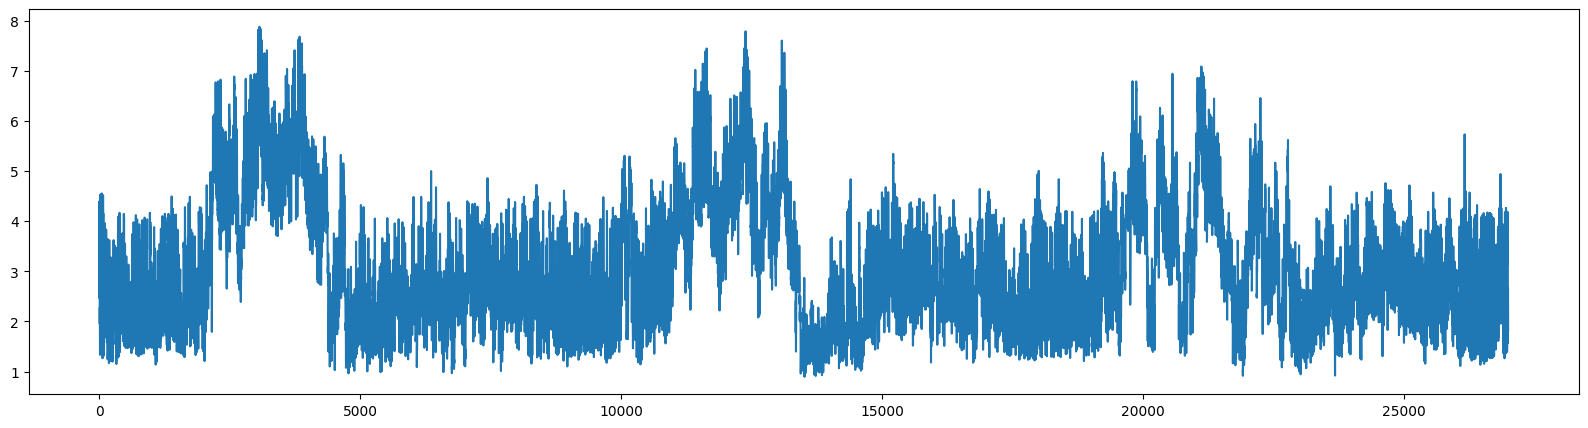

In [84]:
plt.figure(figsize=(20,5))
plt.plot(predictions6h)

In [85]:
#saving the values
pred6h=pd.DataFrame(predictions6h)
pred6h.to_csv('rnn prediction 6h.csv')
y_test.to_csv('rnn test_values 6h.csv')

In [86]:
with open('rnn6h.pickle','wb') as f6:
  pickle.dump(model,f6)

In [87]:
with open('rnn6h.pickle','rb') as f6:
  fm6=pickle.load(f6)

In [88]:
predictions6=fm6.predict(x_test_scaled)

844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [89]:
mse=mean_squared_error(y_test,predictions6)
print("MSE:",mse)

mae=mean_absolute_error(y_test, predictions6)
print("MAE:",mae)

rmse=math.sqrt(mse)
print("RMSE :",rmse)

r2=r2_score(y_test,predictions6)
print("r2 coeffient :",r2)

MSE: 0.7757816617003742
MAE: 0.667680796754588
RMSE : 0.8807846852099407
r2 coeffient : 0.6772922886747305


12 hours wind prediction

In [90]:
df12h=data[["temp.4",'soil_temp.4','solar_rd.1','pressure.3','u10.3','v10.3','wind speed','wind speed.1',"wind speed.2","wind speed.3"]]
df12h

,temp.4,soil_temp.4,solar_rd.1,pressure.3,u10.3,v10.3,wind speed,wind speed.1,wind speed.2,wind speed.3
0,18.869,20.281,1.961410e+07,95848.4,0.155315,1.399950,1.408539,1.123484,0.922119,2.566997
1,18.825,19.913,1.862650e-09,95901.0,0.114499,1.303050,1.308071,0.887458,1.553067,3.115833
2,19.388,19.952,1.086020e+05,95997.9,-0.272937,1.208260,1.238704,0.636728,1.851348,3.408713
3,21.854,22.405,8.415560e+05,96101.7,-0.401350,1.049350,1.123484,0.922119,1.940464,3.495023
4,24.160,25.873,2.294920e+06,96141.0,-0.516890,0.721392,0.887458,1.553067,1.946160,3.752448
...,...,...,...,...,...,...,...,...,...,...
95684,21.018,22.008,1.327630e+07,NaN,-2.551080,NaN,2.551080,2.214200,NaN,NaN
95685,20.924,21.959,1.327630e+07,NaN,-2.560500,NaN,2.560500,2.057840,NaN,NaN
95686,20.944,21.981,1.327630e+07,NaN,-2.294890,NaN,2.294890,NaN,NaN,NaN
95687,20.862,21.939,1.327630e+07,NaN,-2.214200,NaN,2.214200,NaN,NaN,NaN


In [91]:
df12h=df12h[:90000]
x=df12h.iloc[:,:-1]
y=df12h.iloc[:,-1:]

In [92]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,shuffle=False)

In [93]:
scaler=StandardScaler()
scaler.fit(x_train)

StandardScaler()

In [94]:
x_train_scaled=scaler.transform(x_train)
x_test_scaled=scaler.transform(x_test)

In [95]:
x_train_scaled = create_sequence(x_train_scaled, 1)
x_test_scaled  = create_sequence(x_test_scaled, 1)
y_train = y_train[-x_train_scaled.shape[0]:]
y_test  = y_test[-x_test_scaled.shape[0]:]

In [96]:
model = Sequential()

# First LSTM layer
model.add(LSTM(64, input_shape=(x_train_scaled.shape[1:]), activation='tanh', return_sequences=True))
model.add(BatchNormalization())  # Moved BatchNormalization before Dropout
model.add(Dropout(0.2))

# Second LSTM layer
model.add(LSTM(128, activation='tanh', return_sequences=True))  # Set return_sequences=True for deeper LSTMs
model.add(BatchNormalization())
model.add(Dropout(0.3))  # Slightly higher dropout to regularize

# Fourth LSTM layer
model.add(LSTM(128, activation='tanh'))  # Last LSTM layer does not need return_sequences
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Dense layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 1, 64)               │          18,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 1, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 1, 128)              │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 1, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 258,945 (1011.50 KB)

 Trainable params: 258,305 (1009.00 KB)

 Non-trainable params: 640 (2.50 KB)

In [97]:
history= model.fit(x_train_scaled,y_train,validation_split=0.2,epochs=100,batch_size=512)

Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 1.7198 - mean_absolute_error: 1.7198 - val_loss: 2.6333 - val_mean_absolute_error: 2.6333
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.0751 - mean_absolute_error: 1.0751 - val_loss: 2.1766 - val_mean_absolute_error: 2.1766
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9604 - mean_absolute_error: 0.9604 - val_loss: 1.5489 - val_mean_absolute_error: 1.5489
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9055 - mean_absolute_error: 0.9055 - val_loss: 1.0762 - val_mean_absolute_error: 1.0762
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8721 - mean_absolute_error: 0.8721 - val_loss: 0.8799 - val_mean_absolute_error: 0.8799
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.8523 - mean_absolute_error: 0.8523 - val_loss: 0.7728 - val_mean_absolute_error: 0.7728
Epoch 7/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.8412 - mean_absolute_error: 0.8412 - v

In [98]:
predictions12h=model.predict(x_test_scaled)

844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [99]:
mse,mae=model.evaluate(x_test_scaled,y_test)
print("mean squared error",mse)
print("mean absolute error",mae)

rmse=math.sqrt(mse)
rmse

844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.7323 - mean_absolute_error: 0.7323
mean squared error 0.7147113084793091
mean absolute error 0.7147113084793091


0.8454060021547689

In [100]:
#saving the values
pred12h=pd.DataFrame(predictions12h)
pred12h.to_csv('rnn prediction 12h.csv')
y_test.to_csv('rnn test_values 12h.csv')

In [101]:
with open('rnn12h.pickle','wb') as f12:
  pickle.dump(model,f12)

In [102]:
with open('rnn12h.pickle','rb') as f12:
  fm12=pickle.load(f12)

In [103]:
predictions12=fm12.predict(x_test_scaled)

844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [104]:
mse=mean_squared_error(y_test,predictions12)
print("MSE:",mse)

mae=mean_absolute_error(y_test, predictions12)
print("MAE:",mae)

rmse=math.sqrt(mse)
print("RMSE :",rmse)

r2=r2_score(y_test,predictions12)
print("r2 coeffient :",r2)

MSE: 0.8582141579170515
MAE: 0.7147114879158847
RMSE : 0.9263984876482968
r2 coeffient : 0.6430101845784691


In [105]:
df24h=data[["temp.5",'soil_temp.5','solar_rd.4','pressure.4','u10.4','v10.4',"wind speed.4"]]
df24h


,temp.5,soil_temp.5,solar_rd.4,pressure.4,u10.4,v10.4,wind speed.4
0,18.869,20.281,1.961410e+07,95848.4,0.155315,1.399950,1.502179
1,18.825,19.913,1.862650e-09,95901.0,0.114499,1.303050,1.064268
2,19.388,19.952,1.086020e+05,95997.9,-0.272937,1.208260,0.747660
3,21.854,22.405,8.415560e+05,96101.7,-0.401350,1.049350,0.779042
4,24.160,25.873,2.294920e+06,96141.0,-0.516890,0.721392,1.262038
...,...,...,...,...,...,...,...
95684,21.018,22.008,1.327630e+07,NaN,-2.551080,NaN,NaN
95685,20.924,21.959,1.327630e+07,NaN,-2.560500,NaN,NaN
95686,20.944,21.981,1.327630e+07,NaN,-2.294890,NaN,NaN
95687,20.862,21.939,1.327630e+07,NaN,-2.214200,NaN,NaN


In [106]:

df24h=df24h[:90000]
x=df24h.iloc[:,:-1]
y=df24h.iloc[:,-1:]

In [107]:

x['onehour']=data['wind speed']
x['threehour']=data['wind speed.1']
x['sixhour']=data['wind speed.2']
x['twelehour']=data['wind speed.3']

In [108]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,shuffle=False)

In [109]:
scaler=StandardScaler()
scaler.fit(x_train)

StandardScaler()

In [110]:
x_train_scaled=scaler.transform(x_train)
x_test_scaled=scaler.transform(x_test)


In [111]:
x_train_scaled = create_sequence(x_train_scaled, 1)
x_test_scaled  = create_sequence(x_test_scaled, 1)
y_train = y_train[-x_train_scaled.shape[0]:]
y_test  = y_test[-x_test_scaled.shape[0]:]

In [124]:
x_train_scaled.shape

(62999, 1, 10)

In [112]:
model = Sequential()

# First LSTM layer
model.add(LSTM(64, input_shape=(x_train_scaled.shape[1:]), activation='tanh', return_sequences=True))
model.add(BatchNormalization())  # Moved BatchNormalization before Dropout
model.add(Dropout(0.2))

# Second LSTM layer
model.add(LSTM(128, activation='tanh', return_sequences=True))  # Set return_sequences=True for deeper LSTMs
model.add(BatchNormalization())
model.add(Dropout(0.3))  # Slightly higher dropout to regularize

# Fourth LSTM layer
model.add(LSTM(128, activation='tanh'))  # Last LSTM layer does not need return_sequences
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Dense layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                        │ (None, 1, 64)               │          19,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 1, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 1, 128)              │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 1, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 259,201 (1012.50 KB)

 Trainable params: 258,561 (1010.00 KB)

 Non-trainable params: 640 (2.50 KB)

In [113]:
history= model.fit(x_train_scaled,y_train,validation_split=0.2,epochs=100,batch_size=512)


Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 1.6929 - mean_absolute_error: 1.6929 - val_loss: 2.5391 - val_mean_absolute_error: 2.5391
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.9678 - mean_absolute_error: 0.9678 - val_loss: 1.9649 - val_mean_absolute_error: 1.9649
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.8791 - mean_absolute_error: 0.8791 - val_loss: 1.3344 - val_mean_absolute_error: 1.3344
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.8329 - mean_absolute_error: 0.8329 - val_loss: 0.9656 - val_mean_absolute_error: 0.9656
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.8073 - mean_absolute_error: 0.8073 - val_loss: 0.7427 - val_mean_absolute_error: 0.7427
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.7856 - mean_absolute_error: 0.7856 - val_loss: 0.6729 - val_mean_absolute_error: 0.6729
Epoch 7/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.7720 - mean_absolute_error: 0.7720 - v

In [114]:

predictions=model.predict(x_test_scaled)

844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


In [115]:
mse,mae=model.evaluate(x_test_scaled,y_test)
print("mean squared error",mse)
print("mean absolute error",mae)


844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6806 - mean_absolute_error: 0.6806
mean squared error 0.6668434143066406
mean absolute error 0.6668434143066406


In [116]:
rmse=math.sqrt(mse)
rmse

0.8166048091375905

In [117]:
pred24h=pd.DataFrame(predictions)

pred24h.to_csv("Rnnw prediction 24h.csv")
y_test.to_csv('Rnnw test_values 24h.csv')


In [118]:
with open('rnnw24h.pickle','wb') as f24:
  pickle.dump(model,f24)


In [119]:
with open('rnnw24h.pickle','rb') as f24:
  fm24=pickle.load(f24)

In [120]:
predictions24=fm24.predict(x_test_scaled)

844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [121]:
mse=mean_squared_error(y_test,predictions24)
print("MSE:",mse)

mae=mean_absolute_error(y_test, predictions24)
print("MAE:",mae)

rmse=math.sqrt(mse)
print("RMSE :",rmse)

r2=r2_score(y_test,predictions24)
print("r2 coeffient :",r2)

MSE: 0.7385123162737093
MAE: 0.666843506480487
RMSE : 0.8593673930710365
r2 coeffient : 0.6928669522485507
